Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2020/2021  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 4: Procjena parametara, probabilistički grafički modeli i grupiranje

*Verzija: 0.5  
Zadnji put ažurirano: 6. siječnja 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **18. siječnja 2021. u 06:00h**

------------------------------

### Upute

Četvrta laboratorijska vježba sastoji se od tri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno** ili u **tandemu**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [255]:
# Učitaj osnovne biblioteke...
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pgmpy as pgm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [256]:
def plot_silhouette(n_clusters, X):
    # Kôd preuzet s http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.cm.get_cmap("Dark2")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Vrijednosti koeficijenta siluete")
    ax1.set_ylabel("Oznaka grupe")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = plt.cm.get_cmap("Dark2")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=1,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers # changed to black
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="black", alpha=1, s=100, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=80, edgecolor='k')

    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")

    plt.show()

### 1. Procjena maksimalne izglednosti i procjena maksimalne aposteriorne vjerojatnosti

#### (a)

Definirajte funkciju izglednosti $\mathcal{L}(\mu|\mathcal{D})$ za skup $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ Bernoullijevih varijabli. Neka od $N$ varijabli njih $m$ ima vrijednost 1 (npr. od $N$ bacanja novčića, $m$ puta smo dobili glavu). Definirajte funkciju izglednosti tako da je parametrizirana s $N$ i $m$, dakle definirajte funkciju $\mathcal{L}(\mu|N,m)$. 

In [3]:
def L(mu, N, m):
    return mu**m * (1 - mu)**(N - m)

#### (b)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za (1) $N=10$ i $m=1,2,5,9$ te za (2) $N=100$ i $m=1,10,50,90$ (dva zasebna grafikona).

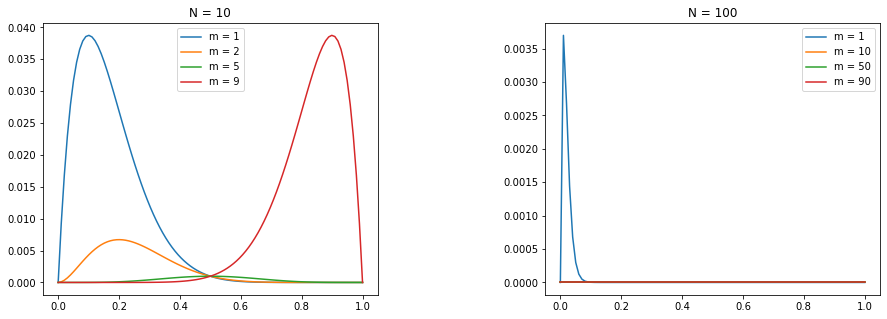

In [36]:
m1 = [1, 2, 5, 9]
m2 = [1, 10, 50, 90]

figure(figsize=(15,5))
subplots_adjust(wspace=0.5, hspace=0.5)

mu = linspace(0, 1, 100)

subplot(1, 2, 1)
title("N = 10")
for m in m1:
    plot(mu, L(mu, 10, m), label='m = {}'.format(m))
legend(loc='best') 

subplot(1, 2, 2)
title("N = 100")
for m in m2:
    plot(mu, L(mu, 100, m), label='m = {}'.format(m))
legend(loc='best') 

**Q:** Koja vrijednost odgovara ML-procjenama i zašto?

#### (c)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za $N=10$ i $m=\{0,9\}$.

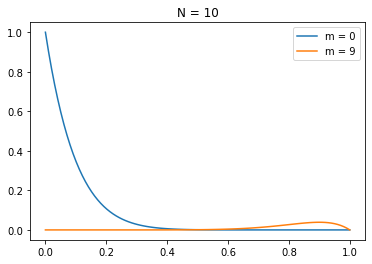

In [35]:
m1 = [0, 9]
mu = linspace(0, 1, 100)

title("N = 10")
for m in m1:
    plot(mu, L(mu, 10, m), label='m = {}'.format(m))
legend(loc='best') 

**Q:** Koja je ML-procjena za $\mu$ i što je problem s takvom procjenom u ovome slučaju?

#### (d)

Prikažite beta-distribuciju $B(\mu|\alpha,\beta)$ za različite kombinacije parametara $\alpha$ i $\beta$, uključivo $\alpha=\beta=1$ te $\alpha=\beta=2$.

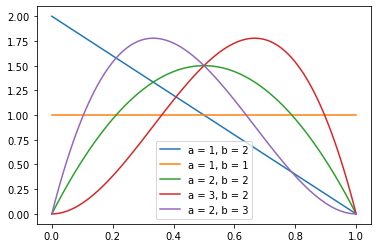

In [29]:
from scipy.stats import beta

mu = linspace(0, 1, 100)

for a,b in zip([1, 1, 2, 3, 2], [2, 1, 2, 2, 3]):
        plot(mu, beta.pdf(mu, a, b), label='a = {}, b = {}'.format(a, b))
        
legend(loc='best') 


**Q:** Koje parametere biste odabrali za modeliranje apriornog znanja o parametru $\mu$ za novčić za koji mislite da je "donekle pravedan, ali malo češće pada na glavu"? Koje biste parametre odabrali za novčić za koji držite da je posve pravedan? Zašto uopće koristimo beta-distribuciju, a ne neku drugu?

#### (e)

Definirajte funkciju za izračun zajedničke vjerojatnosti $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ te prikažite tu funkciju za $N=10$ i $m=9$ i nekolicinu kombinacija parametara $\alpha$ i $\beta$. 

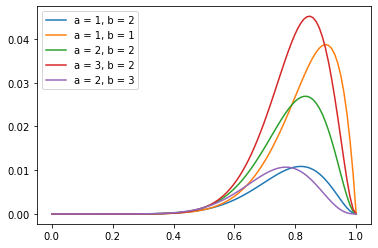

In [32]:
def joined(mu, N, m, a, b):
    return L(mu, N, m) * beta.pdf(mu, a, b)
    
mu = linspace(0, 1, 100)

for a,b in zip([1, 1, 2, 3, 2], [2, 1, 2, 2, 3]):
    plot(mu, joined(mu, 10, 9, a, b), label='a = {}, b = {}'.format(a, b))
        
legend(loc='best') 

**Q**: Koje vrijednosti odgovaraju MAP-procjeni za $\mu$? Usporedite ih sa ML-procjenama.

#### (f)

Za $N=10$ i $m=1$, na jednome grafikonu prikažite sve tri distribucije: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ i $\mathcal{L}(\mu|\mathcal{D})$.

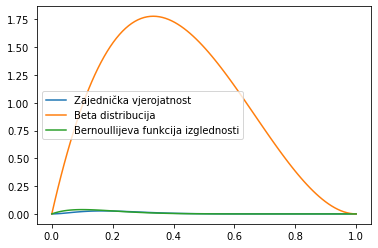

In [37]:
mu = linspace(0, 1, 100)

plot(mu, joined(mu, 10, 1, 2, 2), label='Zajednička vjerojatnost')
plot(mu, beta.pdf(mu, a, b), label='Beta distribucija')
plot(mu, L(mu, 10, 1), label='Bernoullijeva funkcija izglednosti')

legend(loc='best') 

#### (g)

Učitajte skup podataka *Iris* korištenjem funkcije [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Taj skup sadrži $n=4$ značajke i $K=3$ klase. Odaberite jednu klasu i odaberite sve primjere iz te klase, dok ostale primjere zanemarite (**u nastavku radite isključivo s primjerima iz te jedne klase**). Vizualizirajte podatke tako da načinite 2D-prikaze za svaki par značajki (šest grafikona; za prikaz je najjednostavnije koristiti funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)).

**NB:** Mogla bi Vam dobro dući funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

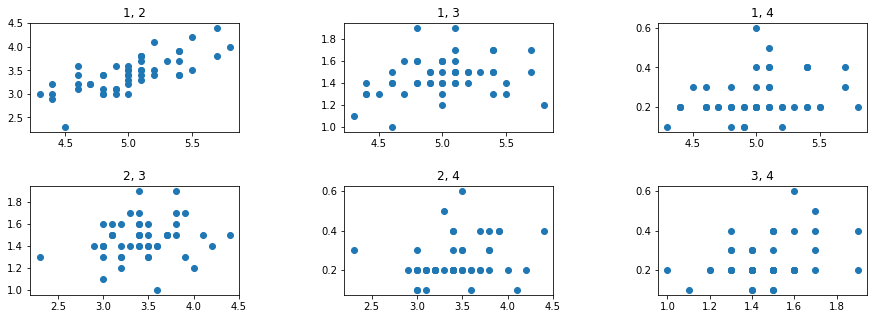

In [100]:
from sklearn.datasets import load_iris
import itertools as it

figure(figsize=(15,5))
subplots_adjust(wspace=0.5, hspace=0.5)

data = load_iris().data
indexes=[0,1,2,3]
combinations = list(it.combinations(indexes,2))

for j in range(6):
    subplot(2, 3, j + 1) 
    x = combinations[j][0]
    y = combinations[j][1]
    plt.title('{}, {}'.format(x + 1, y + 1))
    scatter(data[:50,x], data[:50,y])


#### (h)

Pogledajte opis modula [`stats`](http://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) te proučite funkciju [`norm`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html#scipy.stats.norm). Implementirajte funkciju log-izglednosti za parametre $\mu$ i $\sigma^2$ normalne distribucije.

In [131]:
from scipy.stats import norm

def L_gauss(x, mi, sigma):
    return sum(norm.logpdf(x, loc=mi, scale=sigma))
    

#### (i)
Izračunajte ML-procjene za $(\mu, \sigma^2)$ za svaku od $n=4$ značajki iz skupa *Iris*. Ispišite log-izglednosti tih ML-procjena. 

In [136]:
def mi_MLE(data):
    sum = 0
    for d in data:
        sum = sum + d
    return sum / len(data)

def sigma_2_MLE(data):
    sum = 0
    mi = mi_MLE(data)
    for d in data:
        sum = sum + (d - mi) ** 2
    return sum / len(data)

for i in range(4):
    mi = mi_MLE(data[:50, i])
    sigma_2 = sigma_2_MLE(data[:50, i])
    L = L_gauss(data[:50, i], mi, sigma_2**(1/2))
    print("n =", i + 1, ":") 
    print("mi =", mi, ", sigma^2 =", sigma_2, ", L =", L)

n = 1 :
mi = 5.005999999999999 , sigma^2 = 0.12176399999999993 , L = -18.305163312803867
n = 2 :
mi = 3.428000000000001 , sigma^2 = 0.14081599999999997 , L = -21.939396526466606
n = 3 :
mi = 1.4620000000000002 , sigma^2 = 0.02955600000000001 , L = 17.08978609115976
n = 4 :
mi = 0.2459999999999999 , sigma^2 = 0.010884000000000007 , L = 42.0646097912948


#### (j)

Proučite funkciju [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) za izračun Pearsonovog koeficijenta korelacije. Izračunajte koeficijente korelacije između svih četiri značajki u skupu *Iris*. 

In [140]:
from scipy.stats import pearsonr

for i in range(3):
    for j in range(i + 1, 4):
        p = pearsonr(data[:50, i], data[:50, j])
        print(i + 1, ",", j + 1, ":", p[0])


1 , 2 : 0.7425466856651597
1 , 3 : 0.26717575886875716
1 , 4 : 0.27809835293596963
2 , 3 : 0.1776999667822707
2 , 4 : 0.23275201136287932
3 , 4 : 0.33163004080411873


#### (k)

Proučite funkciju [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) te izračunajte ML-procjenu za kovarijacijsku matricu za skup *Iris*. Usporedite pristranu i nepristranu procjenu. Pokažite da se razlika (srednja apsolutna i kvadratna) smanjuje s brojem primjera (npr. isprobajte za $N/4$ i $N/2$ i $N$ primjera).

In [158]:
for n in [12, 25, 50]:
    biased = np.cov(data[:n, :], rowvar=False, bias=True)
    unbiased = np.cov(data[:n, :], rowvar=False)
    diff = np.mean(abs(biased - unbiased))
    squared = np.mean((biased - unbiased)**2)
    print("N =", n, "\n")
    print("\nPristrana: \n", biased)
    print("\nNepristrana: \n", unbiased)
    print("\nSrednja apsolutna razlika: ", diff)
    print("\nSrednja kvadratna razlika: ", squared)
    print("\n")


N = 12 


Pristrana: 
 [[0.08666667 0.06833333 0.015      0.00583333]
 [0.06833333 0.0825     0.015      0.01166667]
 [0.015      0.015      0.01055556 0.00305556]
 [0.00583333 0.01166667 0.00305556 0.00472222]]

Nepristrana: 
 [[0.09454545 0.07454545 0.01636364 0.00636364]
 [0.07454545 0.09       0.01636364 0.01272727]
 [0.01636364 0.01636364 0.01151515 0.00333333]
 [0.00636364 0.01272727 0.00333333 0.00515152]]

Srednja apsolutna razlika:  0.0023989898989899023

Srednja kvadratna razlika:  1.293849160799922e-05


N = 25 


Pristrana: 
 [[0.154016 0.11336  0.02312  0.018656]
 [0.11336  0.1304   0.006    0.02136 ]
 [0.02312  0.006    0.0376   0.00632 ]
 [0.018656 0.02136  0.00632  0.010496]]

Nepristrana: 
 [[0.16043333 0.11808333 0.02408333 0.01943333]
 [0.11808333 0.13583333 0.00625    0.02225   ]
 [0.02408333 0.00625    0.03916667 0.00658333]
 [0.01943333 0.02225    0.00658333 0.01093333]]

Srednja apsolutna razlika:  0.00184933333333333

Srednja kvadratna razlika:  7.68007149999998

### 2. Probabilistički grafički modeli -- Bayesove mreže

Ovaj zadatak bavit će se Bayesovim mrežama, jednim od poznatijih probabilističkih grafičkih modela (*probabilistic graphical models*; PGM). Za lakše eksperimentiranje koristit ćemo programski paket [`pgmpy`](https://github.com/pgmpy/pgmpy). Molimo Vas da provjerite imate li ovaj paket te da ga instalirate ako ga nemate. Upute se nalaze na gornjoj poveznici. Za korisnike Anaconde, najlakše je upisati `conda install -c ankurankan pgmpy` (ili `pip install pgmpy` ako ne prolazi) unutar Anaconda Prompta (i ponovno pokrenuti Jupyter).

#### (a)  
Prvo ćemo pogledati udžbenički primjer s prskalicom. U ovom primjeru razmatramo Bayesovu mrežu koja modelira zavisnosti između oblačnosti (slučajna varijabla $C$), kiše ($R$), prskalice ($S$) i mokre trave ($W$). U ovom primjeru također pretpostavljamo da već imamo parametre vjerojatnosnih distribucija svih čvorova. Ova mreža prikazana je na sljedećoj slici:

![This](http://www.fer.unizg.hr/_download/repository/bayes-net-sprinkler.jpg)

Koristeći paket `pgmpy`, konstruirajte Bayesovu mrežu iz gornjeg primjera. Zatim, koristeći **egzaktno** zaključivanje, postavite sljedeće posteriorne upite: $P(w=1)$, $P(s=1|w=1)$, $P(r=1|w=1)$, $P(c=1|s=1, r=1)$ i $P(c=1)$. Provedite zaključivanje na papiru i uvjerite se da ste ispravno konstruirali mrežu. Pomoći će vam službena dokumentacija te primjeri korištenja (npr. [ovaj](https://github.com/pgmpy/pgmpy/blob/dev/examples/Monty%20Hall%20Problem.ipynb)).

In [164]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

model = BayesianModel([('C', 'R'), ('C', 'S'), ('S', 'W'), ('R', 'W')])
cpd_c = TabularCPD('C', 2, [[0.5], [0.5]])
cpd_s = TabularCPD('S', 2, [[0.5, 0.9], 
                            [0.5, 0.1]],
                  evidence=['C'], evidence_card=[2])
cpd_r = TabularCPD('R', 2, [[0.8, 0.2], 
                            [0.2, 0.8]],
                  evidence=['C'], evidence_card=[2])
cpd_w = TabularCPD('W', 2, [[1, 0.1, 0.1, 0.01], 
                            [0, 0.9, 0.9, 0.99]],
                  evidence=['S', 'R'], evidence_card=[2, 2])

model.add_cpds(cpd_c, cpd_s, cpd_r, cpd_w)

print(model.get_cpds())
print("\nConstructed correctly:", model.check_model())

[<TabularCPD representing P(C:2) at 0x1c80d85adf0>, <TabularCPD representing P(S:2 | C:2) at 0x1c80c490d00>, <TabularCPD representing P(R:2 | C:2) at 0x1c80c4901f0>, <TabularCPD representing P(W:2 | S:2, R:2) at 0x1c80d4e4f70>]

Constructed correctly: True


In [269]:
infer = VariableElimination(model)

print("P(W)")
w_p = infer.query(['W'])
print(w_p)

print("\nP(S|W=1)")
s_p_w = infer.query(['S'], evidence={'W': 1})
print(s_p_w)

print("\nP(R|W=1)")
r_p_w = infer.query(['R'], evidence={'W': 1})
print(r_p_w)

print("\nP(C|S=1,R=1)")
c_p_s_r = infer.query(['C'], evidence={'S': 1, 'R': 1})
print(c_p_s_r)

print("\nP(C|S=1)")
c_p_s = infer.query(['C'], evidence={'S': 1})
print(c_p_s)

print("\nP(C|R=1)")
c_p_r = infer.query(['C'], evidence={'R': 1})
print(c_p_r)

print("\nP(C)")
c_p = infer.query(['C'])
print(c_p)

Eliminating: S: 100%|██████████| 3/3 [00:00<00:00, 231.39it/s]

P(W)
+------+----------+
| W    |   phi(W) |
+======+==========+
| W(0) |   0.3529 |
+------+----------+
| W(1) |   0.6471 |
+------+----------+

P(S|W=1)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.5702 |
+------+----------+
| S(1) |   0.4298 |
+------+----------+

P(R|W=1)
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.2921 |
+------+----------+
| R(1) |   0.7079 |
+------+----------+

P(C|S=1,R=1)
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5556 |
+------+----------+
| C(1) |   0.4444 |
+------+----------+

P(C|S=1)
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.8333 |
+------+----------+
| C(1) |   0.1667 |
+------+----------+

P(C|R=1)
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.2000 |
+------+----------+
| C(1) |   0.8000 |
+------+----------+

P(C)
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5000 |
+------+-------

**Q:** Koju zajedničku vjerojatnosnu razdiobu ova mreža modelira? Kako tu informaciju očitati iz mreže?  
**Q:** U zadatku koristimo egzaktno zaključivanje. Kako ono radi?  
**Q:** Koja je razlika između posteriornog upita i MAP-upita?  
**Q:** Zašto je vjerojatnost $P(c=1)$ drugačija od $P(c=1|s=1,r=1)$ ako znamo da čvorovi $S$ i $R$ nisu roditelji čvora $C$?

#### (b)  
**Efekt objašnjavanja** (engl. *explaining away*) zanimljiv je fenomen u kojem se događa da se dvije varijable "natječu" za objašnjavanje treće. Ovaj fenomen može se primijetiti na gornjoj mreži. U tom se slučaju varijable prskalice ($S$) i kiše ($R$) "natječu" za objašnjavanje mokre trave ($W$). Vaš zadatak je pokazati da se fenomen zaista događa.

In [179]:
print("\nP(S)")
s_p = infer.query(['S'])
print(s_p)

print("\nP(R)")
r_p = infer.query(['R'])
print(r_p)

print("\nP(S|W=1)")
s_p_w = infer.query(['S'], evidence={'W': 1})
print(s_p_w)

print("\nP(R|W=1)")
r_p_w = infer.query(['R'], evidence={'W': 1})
print(r_p_w)

print("\nP(S|W=1,R=1)")
s_p_w_r = infer.query(['S'], evidence={'W': 1, 'R': 1})
print(s_p_w_r)

print("\nP(R|W=1,S=1)")
r_p_w_s = infer.query(['R'], evidence={'W': 1, 'S': 1})
print(r_p_w_s)


Eliminating: C: 100%|██████████| 1/1 [00:00<00:00, 501.53it/s]


P(S)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.7000 |
+------+----------+
| S(1) |   0.3000 |
+------+----------+

P(R)
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.5000 |
+------+----------+
| R(1) |   0.5000 |
+------+----------+

P(S|W=1)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.5702 |
+------+----------+
| S(1) |   0.4298 |
+------+----------+

P(R|W=1)
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.2921 |
+------+----------+
| R(1) |   0.7079 |
+------+----------+

P(S|W=1,R=1)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.8055 |
+------+----------+
| S(1) |   0.1945 |
+------+----------+

P(R|W=1,S=1)
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.6796 |
+------+----------+
| R(1) |   0.3204 |
+------+----------+


**Q:** Kako biste svojim riječima opisali ovaj fenomen, koristeći se ovim primjerom?

### 3. Grupiranje

U ovom zadatku ćete se upoznati s algoritmom k-sredina (engl. *k-means*), njegovim glavnim nedostatcima te pretpostavkama. Također ćete isprobati i drugi algoritam grupiranja: model Gaussovih mješavina (engl. *Gaussian mixture model*).

#### (a)  
Jedan od nedostataka algoritma k-sredina jest taj što unaprijed zahtjeva broj grupa ($K$) u koje će grupirati podatke. Ta informacija nam često nije dostupna (kao što nam nisu dostupne ni oznake primjera) te je stoga potrebno nekako izabrati najbolju vrijednost hiperparametra $K$. Jedan od naivnijih pristupa jest **metoda lakta/koljena** (engl. *elbow method*) koju ćete isprobati u ovom zadatku.

U svojim rješenjima koristite ugrađenu implementaciju algoritma k-sredina, dostupnoj u razredu [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

**NB**: Kriterijska funkcija algoritma k-sredina još se i naziva **inercijom** (engl. *inertia*). Za naučeni model, vrijednost kriterijske funkcije $J$ dostupna je kroz razredni atribut `inertia_`.

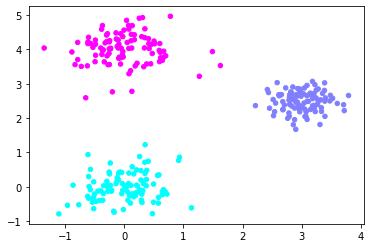

In [185]:
from sklearn.datasets import make_blobs

Xp, yp = make_blobs(n_samples=300, n_features=2, centers=[[0, 0], [3, 2.5], [0, 4]], 
                    cluster_std=[0.45, 0.3, 0.45], random_state=96)
plt.scatter(Xp[:,0], Xp[:,1], c=yp, cmap=plt.get_cmap("cool"), s=20)

Iskoristite skup podataka `Xp` dan gore. Isprobajte vrijednosti hiperparametra $K$ iz $[0,1,\ldots,15]$. Ne trebate dirati nikakve hiperparametre modela osim $K$. Iscrtajte krivulju od $J$ u ovisnosti o broju grupa $K$. Metodom lakta/koljena odredite vrijednost hiperparametra $K$.

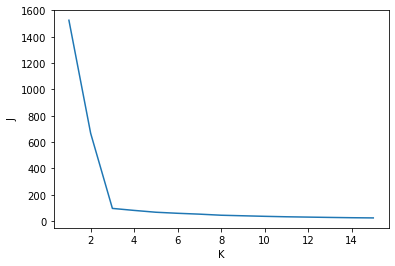

In [187]:
from sklearn.cluster import KMeans

K = range(1,16)
J = []

for k in K:
    kmeans = KMeans(n_clusters=k).fit(Xp)
    J.append(kmeans.inertia_)
    
plt.xlabel("K")
plt.ylabel("J")
plot(K, J)


**Q:** Koju biste vrijednost hiperparametra $K$ izabrali na temelju ovog grafa? Zašto? Je li taj odabir optimalan? Kako to znate?    
**Q:** Je li ova metoda robusna?  
**Q:** Možemo li izabrati onaj $K$ koji minimizira pogrešku $J$? Objasnite.

#### (b)  
Odabir vrijednosti hiperparametra $K$ može se obaviti na mnoštvo načina. Pored metode lakta/koljena, moguće je isto ostvariti i analizom siluete (engl. *silhouette analysis*). Za to smo pripremili funkciju `plot_silhouette` koja za dani broj grupa i podatke iscrtava prosječnu vrijednost koeficijenta siluete i vrijednost koeficijenta svakog primjera (kroz grupe). 

Vaš je zadatak isprobati različite vrijednosti hiperparametra $K$, $K \in \{2, 3, 5\}$ i na temelju dobivenih grafova odlučiti se za optimalan $K$.

For n_clusters = 2 The average silhouette_score is : 0.59280796169837


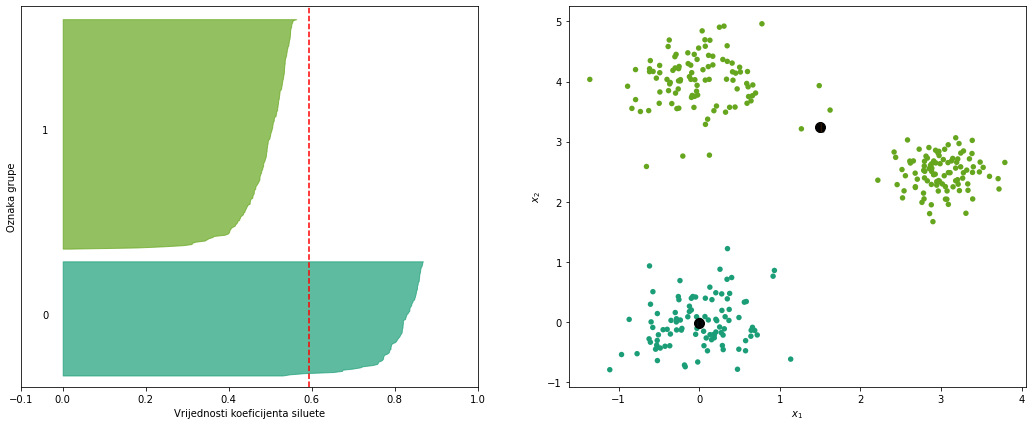

For n_clusters = 3 The average silhouette_score is : 0.7975462212061406


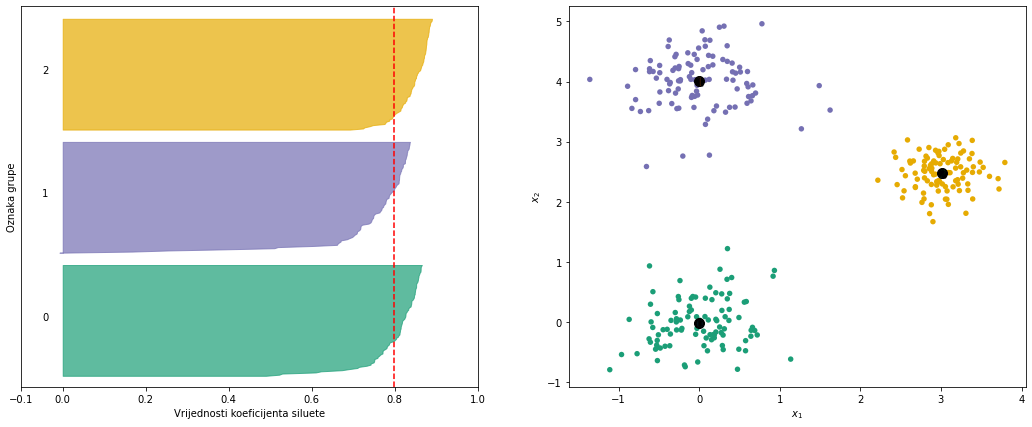

For n_clusters = 5 The average silhouette_score is : 0.5059026123508755


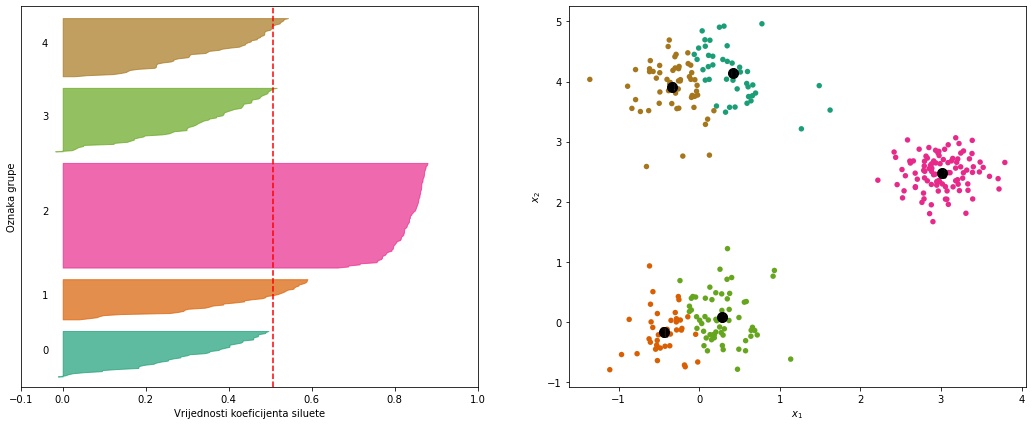

In [188]:
K = [2, 3, 5]
for k in K:
    plot_silhouette(k, Xp)

**Q:** Kako biste se gledajući ove slike odlučili za $K$?  
**Q:** Koji su problemi ovog pristupa?

#### (c)  
U ovom i sljedećim podzadatcima fokusirat ćemo se na temeljne pretpostavke algoritma k-sredina te što se događa ako te pretpostavke nisu zadovoljene. Dodatno, isprobat ćemo i grupiranje modelom Gaussovih mješavina (engl. *Gaussian Mixture Models*; GMM) koji ne nema neke od tih pretpostavki.

Prvo, krenite od podataka `X1`, koji su generirani korištenjem funkcije [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), koja stvara grupe podataka pomoću izotropskih Gaussovih distribucija.

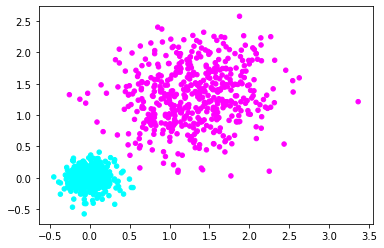

In [189]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), s=20)

Naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

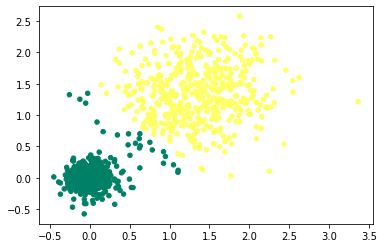

In [257]:
kmeans_1 = KMeans(n_clusters=2).fit(X1)
plt.scatter(X1[:,0], X1[:,1], c=kmeans_1.predict(X1), cmap=plt.get_cmap("summer"), s=20)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (d)

Isprobajte algoritam k-sredina na podatcima generiranim korištenjem funkcije [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), koja stvara dvije grupe podataka tako da je jedna unutar druge.

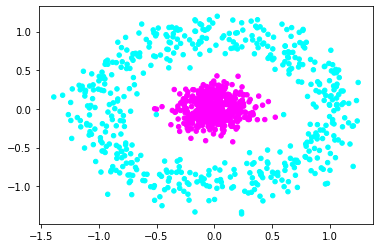

In [192]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), s=20)

Ponovno, naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

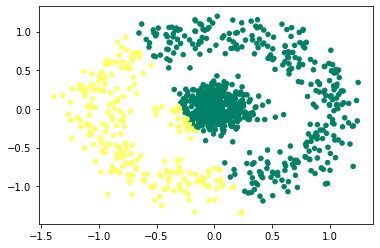

In [263]:
kmeans_2 = KMeans(n_clusters=2).fit(X2)
plt.scatter(X2[:,0], X2[:,1], c=kmeans_2.predict(X2), cmap=plt.get_cmap("summer"), s=20)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (e)  
Završno, isprobat ćemo algoritam na sljedećem umjetno stvorenom skupu podataka:

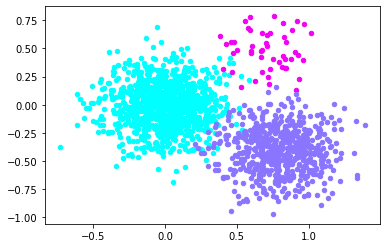

In [199]:
X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", s=20)
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", s=20)
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", s=20)

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

Ponovno, naučite model k-sredina (ovaj put idealno pretpostavljajući $K=3$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

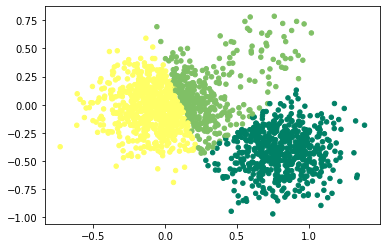

In [264]:
kmeans_3 = KMeans(n_clusters=3).fit(X3)
plt.scatter(X3[:,0], X3[:,1], c=kmeans_3.predict(X3), cmap=plt.get_cmap("summer"), s=20)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (f)  
Sada kada ste se upoznali s ograničenjima algoritma k-sredina, isprobat ćete grupiranje modelom mješavine Gaussa (*Gaussian Mixture Models; GMM*), koji je generalizacija algoritma k-sredina (odnosno, algoritam k-sredina specijalizacija je GMM-a). Implementacija ovog modela dostupna je u [`mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). Isprobajte ovaj model (s istim pretpostavkama o broju grupa) na podacima iz podzadataka (c)-(e). Ne morate mijenjati nikakve hiperparametre ni postavke osim broja komponenti.

In [217]:
from sklearn.mixture import GaussianMixture

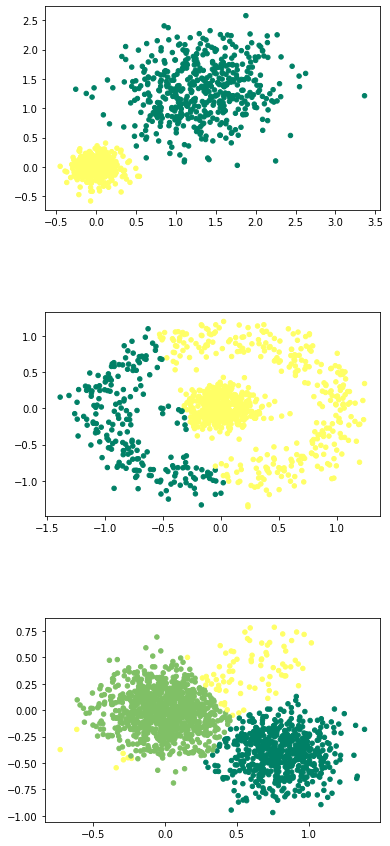

In [249]:
figure(figsize=(6,15))
subplots_adjust(wspace=0.5, hspace=0.5)

gm_1 = GaussianMixture(n_components=2).fit(X1)
subplot(3, 1, 1)
plt.scatter(X1[:,0], X1[:,1], c=gm_1.predict(X1), cmap=plt.get_cmap("summer"), s=20)

gm_2 = GaussianMixture(n_components=2).fit(X2)
subplot(3, 1, 2)
plt.scatter(X2[:,0], X2[:,1], c=gm_2.predict(X2), cmap=plt.get_cmap("summer"), s=20)

gm_3 = GaussianMixture(n_components=3).fit(X3)
subplot(3, 1, 3)
plt.scatter(X3[:,0], X3[:,1], c=gm_3.predict(X3), cmap=plt.get_cmap("summer"), s=20)

#### (g)  
Kako vrednovati točnost modela grupiranja ako imamo stvarne oznake svih primjera (a u našem slučaju imamo, jer smo mi ti koji smo generirali podatke)? Često korištena mjera jest **Randov indeks** koji je zapravo pandan točnosti u zadatcima klasifikacije. Implementirajte funkciju `rand_index_score(y_gold, y_predict)` koja ga računa. Funkcija prima dva argumenta: listu stvarnih grupa kojima primjeri pripadaju (`y_gold`) i listu predviđenih grupa (`y_predict`). Dobro će vam doći funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [266]:
import itertools as it

def rand_index_score(y_gold, y_predict):
    n = len(y_gold)
    c_gold = it.combinations(y_gold,2)
    c_pred = it.combinations(y_predict,2)
    a = 0
    b = 0
    c = 0
    for g, p in zip(c_gold, c_pred):
        if g[0] == g[1] and p[0] == p[1]:
            a = a + 1
        if g[0] != g[1] and p[0] != p[1]:
            b = b + 1
        c = c + 1
    return (a + b) / c
    
print("Algoritam k-sredina:")
print("Randov indeks za X1:", rand_index_score(y1, kmeans_1.predict(X1)))
print("Randov indeks za X2:", rand_index_score(y2, kmeans_2.predict(X2)))
print("Randov indeks za X3:", rand_index_score(y3, kmeans_3.predict(X3)))

print("\nModel Gaussove mješavine:")
print("Randov indeks za X1:", rand_index_score(y1, gm_1.predict(X1)))
print("Randov indeks za X2:", rand_index_score(y2, gm_2.predict(X2)))
print("Randov indeks za X3:", rand_index_score(y3, gm_3.predict(X3)))

Algoritam k-sredina:
Randov indeks za X1: 0.9531051051051052
Randov indeks za X2: 0.5643643643643643
Randov indeks za X3: 0.3519738317070033

Model Gaussove mješavine:
Randov indeks za X1: 1.0
Randov indeks za X2: 0.5733013013013013
Randov indeks za X3: 0.4780667806016502


**Q:** Zašto je Randov indeks pandan točnosti u klasifikacijskim problemima?  
**Q:** Koji su glavni problemi ove metrike?   
**Q:** Kako vrednovati kvalitetu grupiranja ako nenamo stvarne oznake primjera? Je li to uopće moguće?